<h1>Fine-tuning BERT Models for Classification</h1>

In [1]:
%%capture
!pip install "datasets>=2.18.0,<3" transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

## **Data**

In [2]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

## **Supervised Classification**

### HuggingFace Trainer

In [3]:
'''AutoTokenizer: Automatically loads the correct tokenizer class (e.g., BertTokenizer, RobertaTokenizer) based on the model name.
AutoModelForSequenceClassification: Automatically loads a model class designed for sequence classification (e.g., sentiment analysis, entailment, etc.).'''
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
'''Specifies the model checkpoint from Hugging Face’s Model Hub.bert-base-cased:BERT base model (12 layers, 110M parameters)
Uses cased tokens (keeps capitalization, unlike uncased models)'''
model_id = "bert-base-cased"

'''Loads a pretrained BERT model for classification tasks. num_labels=2: Sets the model's classification head to output 2 logits, typically used for binary classification 
(e.g., "entailment" vs. "not entailment").
from_pretrained(...): Downloads the model weights from Hugging Face. Loads BERT’s encoder and attaches a new classification head on top'''
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

'''Loads the tokenizer that matches the bert-base-cased model. This tokenizer: Splits text into tokens (word pieces). Converts tokens to input IDs
Pads, truncates, and creates attention masks as needed'''
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize our data.

In [4]:
'''A data collator dynamically pads inputs in a batch to the longest sequence length in that batch — not globally.
This saves memory and speeds up training compared to padding all inputs to a fixed max length.'''
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
'''Uses the tokenizer's padding rules (e.g., pad token ID). Later, you pass this data_collator into a Trainer or DataLoader for smart batching.'''
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

'''Tokenizes each input string in the dataset. examples["text"] assumes your dataset has a column named "text" (can be "sentence", "input", etc. depending on your dataset).
truncation=True: Truncates long inputs to the model's max length (usually 512 for BERT).'''
def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
'''map(...): Applies your preprocess_function to every item in the dataset. batched=True: Processes multiple samples at once (faster). Adds tokenized fields like:
input_ids, attention_mask, (optionally) token_type_ids'''
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Define metrics.

In [5]:
import numpy as np
'''evaluate is Hugging Face’s unified library for evaluation metrics (like f1, accuracy, bleu, etc.).'''
import evaluate

'''eval_pred is a tuple: (logits, true_labels). logits: raw model outputs before softmax. labels: ground-truth labels.'''
def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    '''Loads the F1 metric using the evaluate library. Computes the F1 score using the predicted and true labels.'''
    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

Train model.

In [6]:
from transformers import TrainingArguments, Trainer
'''| Parameter                        | Meaning                                                |
| -------------------------------- | ------------------------------------------------------ |
| `"model"`                        | Output directory where model checkpoints will be saved |
| `learning_rate=2e-5`             | Common learning rate for fine-tuning BERT-like models  |
| `per_device_train_batch_size=16` | Batch size for training (per GPU)                      |
| `per_device_eval_batch_size=16`  | Batch size for evaluation                              |
| `num_train_epochs=1`             | Train for 1 epoch (can increase later)                 |
| `weight_decay=0.01`              | Adds L2 regularization to prevent overfitting          |
| `save_strategy="epoch"`          | Saves model at the end of every epoch                  |
| `report_to="none"`               | Disables logging to tools like W\&B, TensorBoard, etc. |
'''

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)
'''| Argument          | Purpose                                                                   |
| ----------------- | ------------------------------------------------------------------------- |
| `model`           | The model you loaded earlier (`bert-base-cased` with classification head) |
| `args`            | Your training configuration                                               |
| `train_dataset`   | Tokenized training dataset                                                |
| `eval_dataset`    | Tokenized evaluation dataset                                              |
| `tokenizer`       | Used for saving and padding data correctly                                |
| `data_collator`   | Pads batches dynamically for efficient training                           |
| `compute_metrics` | Custom evaluation (e.g., F1 score you defined earlier)                    |
 '''

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


<>:11: SyntaxWarning: invalid escape sequence '\&'
<>:11: SyntaxWarning: invalid escape sequence '\&'
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3114871731.py:11: SyntaxWarning: invalid escape sequence '\&'
  | `report_to="none"`               | Disables logging to tools like W\&B, TensorBoard, etc. |
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3114871731.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
trainer.train()

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.406100


TrainOutput(global_step=534, training_loss=0.402509808986821, metrics={'train_runtime': 1516.7754, 'train_samples_per_second': 5.624, 'train_steps_per_second': 0.352, 'total_flos': 227605451772240.0, 'train_loss': 0.402509808986821, 'epoch': 1.0})

Evaluate results.

In [8]:
trainer.evaluate()

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.36064156889915466,
 'eval_f1': 0.8533585619678334,
 'eval_runtime': 47.6687,
 'eval_samples_per_second': 22.363,
 'eval_steps_per_second': 1.406,
 'epoch': 1.0}

### Freeze Layers

In [9]:
# Load Model and Tokenizer
'''Loads a pretrained model (e.g., BERT, RoBERTa) with a classification head on top. model_id: could be 'bert-base-cased', 'roberta-base', or any other Hugging Face model name.
num_labels=2: sets the output head for binary classification (2 classes). You can change this to match your task.
What the model outputs: A tensor of shape [batch_size, num_labels], representing logits for each class.'''
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

'''Loads the corresponding tokenizer for the specified model. It handles: Text cleaning, Tokenization (splitting words into tokens or subwords), Conversion to token IDs
Adding special tokens like [CLS], [SEP], Attention masks and padding'''
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [11]:
'''This is a form of transfer learning, where you: Use the pretrained model as a frozen feature extractor.
Only fine-tune the final classification head (typically a small number of parameters). You can selectively unfreeze the last few layers (for more adaptability) like this:
    for name, param in model.named_parameters():
    if name.startswith("classifier") or "encoder.layer.11" in name or "encoder.layer.10" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
 '''
#This code is freezing most of your model’s layers, except for the classification head, which you keep trainable.
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

In [12]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
     print(f"Parameter: {name} ----- {param.requires_grad}")

Parameter: bert.embeddings.word_embeddings.weight ----- False
Parameter: bert.embeddings.position_embeddings.weight ----- False
Parameter: bert.embeddings.token_type_embeddings.weight ----- False
Parameter: bert.embeddings.LayerNorm.weight ----- False
Parameter: bert.embeddings.LayerNorm.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: bert.encoder.layer.0.attention.output

In [13]:
#this code is launching the fine-tuning process for your classification model using Hugging Face's Trainer
'''| Parameter         | Description                                                                                                                      |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| `model`           | Your pretrained BERT-like model with a classification head, where only the `classifier` layer is trainable (you froze the rest). |
| `args`            | Training settings like batch size, learning rate, number of epochs, save strategy, etc. (from `TrainingArguments`).              |
| `train_dataset`   | Your tokenized training dataset.                                                                                                 |
| `eval_dataset`    | Your tokenized validation set (used for evaluation after each epoch).                                                            |
| `tokenizer`       | Used to process text during training (e.g., saving the model properly).                                                          |
| `data_collator`   | Automatically pads inputs in a batch to the longest input in that batch (efficient and GPU-friendly).                            |
| `compute_metrics` | Your custom function to calculate F1 score (can add accuracy, precision, etc. too).                                              |
 '''
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
'''Behind the Scenes When You Call trainer.train() Dataset is loaded in batches, with dynamic padding via data_collator.
Model is trained for the number of epochs you set (num_train_epochs=1 in your case).
After each epoch: Model is evaluated on the validation dataset. F1 score is computed and printed. If save_strategy="epoch" was set (as in your case), 
it saves the model checkpoint after each epoch. Progress bar + training logs are shown unless disabled.'''
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\386210857.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.704600


TrainOutput(global_step=534, training_loss=0.7044561864731463, metrics={'train_runtime': 603.8468, 'train_samples_per_second': 14.126, 'train_steps_per_second': 0.884, 'total_flos': 227605451772240.0, 'train_loss': 0.7044561864731463, 'epoch': 1.0})

In [14]:
trainer.evaluate()

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6915770769119263,
 'eval_f1': 0.6515704894083273,
 'eval_runtime': 55.8284,
 'eval_samples_per_second': 19.094,
 'eval_steps_per_second': 1.2,
 'epoch': 1.0}

### Freeze blocks 1-5

In [15]:
# We can check whether the model was correctly updated
for index, (name, param) in enumerate(model.named_parameters()):
     print(f"Parameter: {index}{name} ----- {param.requires_grad}")

Parameter: 0bert.embeddings.word_embeddings.weight ----- False
Parameter: 1bert.embeddings.position_embeddings.weight ----- False
Parameter: 2bert.embeddings.token_type_embeddings.weight ----- False
Parameter: 3bert.embeddings.LayerNorm.weight ----- False
Parameter: 4bert.embeddings.LayerNorm.bias ----- False
Parameter: 5bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: 6bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: 7bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: 8bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: 9bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: 10bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: 11bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: 12bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: 13bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: 14bert.encoder.laye

In [16]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 10 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\2122135607.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.472500


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4012673795223236,
 'eval_f1': 0.8140417457305503,
 'eval_runtime': 55.2558,
 'eval_samples_per_second': 19.292,
 'eval_steps_per_second': 1.213,
 'epoch': 1.0}

### [BONUS] Freeze blocks

In [17]:
#This code is experimenting with gradual unfreezing of the transformer layers in a BERT model, to see how different layers affect performance on a classification task.
'''Training with Layer-Freezing Strategy:
The loop runs 12 iterations (from index = 0 to index = 11), progressively freezing more layers in the model during each iteration.
Layer Freezing Logic: In each iteration:
It re-loads a fresh version of the BERT model (bert-base-cased).
Freezes the layers of the model based on the current index (which corresponds to the layer number being unfrozen).
Layers that have an index less than or equal to the current index are frozen.'''
scores = []
for index in range(12):
    # Re-load model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # Freeze encoder blocks 0-index
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # Train
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # Evaluate
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.406000


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.408300


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.409900


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.411000


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.413000


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.416800


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.421800


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.429100


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.444900


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.468900


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.509500


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3529723155.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.663700


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [18]:
scores

[0.8477443609022557,
 0.8431924882629108,
 0.8428974600188147,
 0.839622641509434,
 0.8398104265402844,
 0.8387096774193549,
 0.8358490566037736,
 0.832391713747646,
 0.8320754716981132,
 0.8174904942965779,
 0.7953667953667953,
 0.7049742710120068]

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 16.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 25.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 26.9 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------

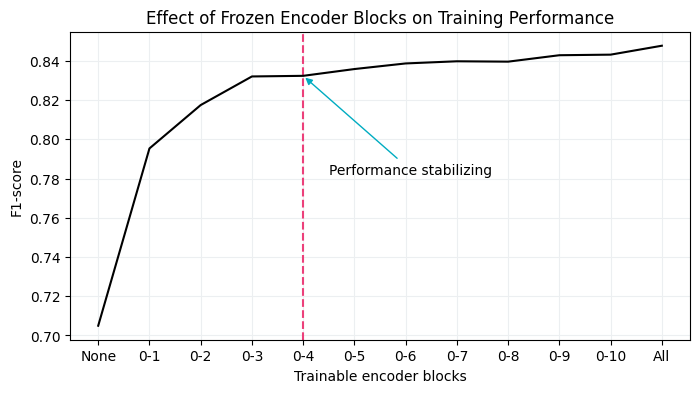

In [20]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Create Figure
plt.figure(figsize=(8,4))

# Prepare Data
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = [
    0.8477443609022557,
 0.8431924882629108,
 0.8428974600188147,
 0.839622641509434,
 0.8398104265402844,
 0.8387096774193549,
 0.8358490566037736,
 0.832391713747646,
 0.8320754716981132,
 0.8174904942965779,
 0.7953667953667953,
 0.7049742710120068
][::-1]

# Stylize Figure
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# Plot Data
plt.plot(x, y, color="black")

# Additional Annotation
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

## Few-shot Classification

In [21]:
'''This imports the sample_dataset utility function from the SetFit library.
SetFit is a framework for efficient few-shot fine-tuning of Sentence Transformers.
The sample_dataset function helps reduce a dataset to a smaller few-shot subset by randomly sampling examples.'''
from setfit import sample_dataset

# We simulate a few-shot setting by sampling 16 examples per class
'''This code is taking the training split of the tomatoes dataset and creating a few-shot version of it by sampling 16 examples per class. That smaller dataset will then be used to train a model in a low-data setting.'''
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [22]:
#A SetFitModel is essentially a sentence transformer (for embeddings) wrapped with a classification head (so it can be fine-tuned on classification tasks).
from setfit import SetFitModel

# Load a pre-trained SentenceTransformer model
'''SetFitModel.from_pretrained(...) is a class method that loads a model checkpoint.
"sentence-transformers/all-mpnet-base-v2" is a pre-trained Sentence Transformer hosted on the Hugging Face Hub.
all-mpnet-base-v2 is one of the strongest general-purpose embedding models, built on Microsoft’s MPNet architecture.
It encodes text into dense vector representations (embeddings).
Under the hood:The Sentence Transformer backbone (all-mpnet-base-v2) is loaded. A classification head is added on top, but initially untrained.
You can then fine-tune this model with few-shot learning'''
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [23]:
'''Contrastive learning phase: Model takes sentence pairs (generated via num_iterations) and learns embeddings by pulling similar pairs together and pushing different pairs apart.
Classifier training phase: A lightweight classifier head (often logistic regression) is trained on top of embeddings to perform your target classification task.
Evaluation: On test_data, trainer computes the F1-score to track model performance.'''
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# Define training arguments
args = SetFitTrainingArguments(
    num_epochs=3, # The number of epochs to use for contrastive learning
    num_iterations=20  # The number of text pairs to generate
)
args.eval_strategy = args.evaluation_strategy

# Create trainer
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [24]:
from setfit import SetFitTrainer

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1",
    num_epochs=3, # The number of epochs to use for contrastive learning
)

C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\851602375.py:4: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [25]:
# Training loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.299600
50,0.110400
100,0.001000
150,0.000500
200,0.000300


In [26]:
# Evaluate the model on our test data
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.8450433108758422}

In [27]:
model.model_head

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## MLM

In [28]:
#This code loads BERT for MLM with its tokenizer, so you can run masked token prediction or fine-tune BERT on a downstream MLM task.
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model for Masked Language Modeling (MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Tokenize data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [30]:
'''A data collator is a helper that:Takes raw tokenized examples from your dataset. Batches them together.
Applies on-the-fly masking for MLM (instead of masking everything ahead of time).'''
from transformers import DataCollatorForLanguageModeling
'''For each batch: Pick 15% of tokens at random. Replace them as follows (again, standard BERT trick):
80% → [MASK] token
10% → random word from vocab
10% → left unchanged
Model’s loss is computed only on these masked tokens.'''

# Masking Tokens
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [31]:
from transformers import DataCollatorForWholeWordMask

# Masking Whole Words, it masks entire words instead of just random subword tokens
data_collator = DataCollatorForWholeWordMask(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [32]:
# Training arguments for parameter tuning
'''TrainingArguments:
A Hugging Face helper class where you define all your training hyperparameters and settings.
Arguments explained:
"model" → output directory where checkpoints and logs will be saved.
learning_rate=2e-5 → small learning rate, standard for fine-tuning BERT.
per_device_train_batch_size=16 → batch size per GPU/CPU during training.
per_device_eval_batch_size=16 → batch size for evaluation.
num_train_epochs=10 → train for 10 full passes through the dataset.
weight_decay=0.01 → regularization to avoid overfitting.
save_strategy="epoch" → save model checkpoint after every epoch.
report_to="none" → disables logging to WandB/Comet/MLflow by default.'''
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

'''Trainer:
High-level API that abstracts away the whole training loop (forward pass, backward pass, optimizer, evaluation).
Arguments:
model=model → the MLM model (e.g., BertForMaskedLM) you loaded earlier.
args=training_args → hyperparameters/settings you just defined.
train_dataset=tokenized_train → your training dataset, already tokenized.
eval_dataset=tokenized_test → your evaluation dataset.
tokenizer=tokenizer → ensures Trainer can handle padding, truncation, etc.
data_collator=data_collator → defines how batches are formed (e.g., with random masking if you used DataCollatorForLanguageModeling or whole-word masking if you used DataCollatorForWholeWordMask).'''
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\3188571048.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
# Save pre-trained tokenizer
tokenizer.save_pretrained("mlm")

# Train model
trainer.train()

# Save updated model
model.save_pretrained("mlm")

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
500,3.106300
1000,2.885400
1500,2.806700
2000,2.707700
2500,2.667000
3000,2.622400
3500,2.570500
4000,2.509100
4500,2.509700
5000,2.483900


C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\

In [34]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [35]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cpu


>>> What a horrible mess!
>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible thing!
>>> What a horrible story!


## Named Entity Recognition

Here are a number of interesting datasets you can also explore for NER:
* tner/mit_movie_trivia
* tner/mit_restaurant
* wnut_17
* conll2003

In [36]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [37]:
# The CoNLL-2003 dataset for NER
dataset = load_dataset("conll2003", trust_remote_code=True)

Using the latest cached version of the module from C:\Users\aitra\.cache\huggingface\modules\datasets_modules\datasets\conll2003\9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98 (last modified on Sat Aug 23 19:04:56 2025) since it couldn't be found locally at conll2003, or remotely on the Hugging Face Hub.


In [38]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [39]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [40]:
from transformers import AutoModelForTokenClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Split individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

In [42]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # Map tokens to their respective word
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # The start of a new word
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # Special token is -100
            elif word_idx is None:
                label_ids.append(-100)

            # If the label is B-XXX we change it to I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [43]:
# Difference between original and updated labels
print(f"Original: {example['ner_tags']}")
print(f"Updated: {tokenized['train'][848]['labels']}")

Original: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [44]:
import evaluate

# Load sequential evaluation
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # Create predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # Document-level iteration
    for prediction, label in zip(predictions, labels):

      # token-level iteration
      for token_prediction, token_label in zip(prediction, label):

        # We ignore special tokens
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [45]:
from transformers import DataCollatorForTokenClassification

# Token-classification Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [46]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

C:\Users\aitra\AppData\Local\Temp\ipykernel_2308\1046598781.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.232300


TrainOutput(global_step=878, training_loss=0.16677095026524572, metrics={'train_runtime': 2018.2841, 'train_samples_per_second': 6.957, 'train_steps_per_second': 0.435, 'total_flos': 351240792638148.0, 'train_loss': 0.16677095026524572, 'epoch': 1.0})

In [47]:
# Evaluate the model on our test data
trainer.evaluate()

C:\Users\aitra\anaconda3\envs\llm\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.14675407111644745,
 'eval_f1': 0.9028946697271105,
 'eval_runtime': 107.6315,
 'eval_samples_per_second': 32.082,
 'eval_steps_per_second': 2.007,
 'epoch': 1.0}

In [48]:
from transformers import pipeline

# Save our fine-tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

Device set to use cpu


[{'entity': 'B-PER',
  'score': np.float32(0.9826962),
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': np.float32(0.9714426),
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': np.float32(0.9533223),
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]